# Applying `RCTD` and `MCube` to ST datasets segmented by different methods

In [1]:
set.seed(20240709)

library(Matrix)
library(spacexr)
library(MCube)
library(ggplot2)

max_cores <- 36

In [2]:
DATA_PATH <- "/import/home/share/zw/pql/data/breast_cancer"
RESULT_PATH <- "/import/home/share/zw/pql/results/breast_cancer"

if (!dir.exists(RESULT_PATH)) {
    dir.create(RESULT_PATH, recursive = TRUE)
}

In [3]:
# Load in scRNA-seq reference data

sc_counts <- as.data.frame(readr::read_csv(file.path(DATA_PATH, "rawdata", "sc_counts.csv")))
rownames(sc_counts) <- sc_counts[, 1]
sc_counts[, 1] <- NULL
# head(sc_counts)

sc_celltype <- read.csv(file.path(DATA_PATH, "rawdata", "sc_celltype.csv"))
celltypes <- sc_celltype$celltype
names(celltypes) <- sc_celltype[, 1]
celltypes <- factor(celltypes, levels = unique(celltypes))

reference <- Reference(t(as.matrix(sc_counts)), celltypes, rowSums(sc_counts), min_UMI = 10)

New names:
• `` -> `...1`
Rows: 26031 Columns: 308
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): ...1
dbl (307): IL2RG, SNAI1, GLIPR1, OXTR, MYBPC1, MUC6, PDK4, KLRB1, RUNX1, DSP...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in check_UMI(nUMI, "Reference", require_2d = T, require_int = require_int, :
“Reference: some nUMI values are less than min_UMI = 10, and these cells will be removed. Optionally, you may lower the min_UMI parameter.”


## Cells segmented by the `10x` method

### Cell type deconvolution using `RCTD`

In [4]:
seg_method <- "Cell_10X"

counts <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "counts.csv")
))
rownames(counts) <- counts[, 1]
counts[, 1] <- NULL
counts <- as.matrix(counts)
# head(counts)

coordinates <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "coordinates.csv")
))
rownames(coordinates) <- coordinates[, 1]
coordinates[, 1] <- NULL
coordinates <- as.matrix(coordinates)
# head(coordinates)

scvi_label <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "scvi_label.csv")
))
rownames(scvi_label) <- scvi_label[, 1]
scvi_label <- scvi_label[, 2]
# head(scvi_label)

puck <- SpatialRNA(as.data.frame(coordinates), t(counts), rowSums(counts))

New names:
• `` -> `...1`
Rows: 10000 Columns: 308
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (308): ...1, SFRP1, PCLAF, CDC42EP1, LGALSL, CCL5, USP53, IGF1, ESM1, MN...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 10000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): ...1, x, y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 10000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): celltype
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_type

In [5]:
myRCTD <- create.RCTD(
    puck, reference,
    UMI_min = 50, max_cores = max_cores
)
myRCTD <- run.RCTD(myRCTD, doublet_mode = "multi")
saveRDS(myRCTD, file.path(RESULT_PATH, seg_method, "myRCTD.rds"))

# myRCTD <- readRDS(file.path(RESULT_PATH, seg_method, "myRCTD.rds"))

Begin: process_cell_type_info

process_cell_type_info: number of cells in reference: 25968

process_cell_type_info: number of genes in reference: 307




              Stromal         Macrophages 1     Perivascular-Like 
                 2598                  2960                   280 
        Myoepi ACTA2+          CD4+ T Cells                DCIS 1 
                 1234                  2883                  1861 
Prolif Invasive Tumor        Invasive Tumor          CD8+ T Cells 
                 1329                  4554                  1839 
          Endothelial         Macrophages 2                DCIS 2 
                 1053                   760                  2159 
              B Cells             IRF7+ DCs            Mast Cells 
                 1450                   210                    92 
           LAMP3+ DCs         Myoepi KRT15+ 
                  103                   603 


End: process_cell_type_info

create.RCTD: getting regression differentially expressed genes: 

get_de_genes: Stromal found DE genes: 33

get_de_genes: Macrophages 1 found DE genes: 36

get_de_genes: Perivascular-Like found DE genes: 36

get_de_genes: Myoepi ACTA2+ found DE genes: 30

get_de_genes: CD4+ T Cells found DE genes: 48

get_de_genes: DCIS 1 found DE genes: 23

get_de_genes: Prolif Invasive Tumor found DE genes: 21

get_de_genes: Invasive Tumor found DE genes: 16

get_de_genes: CD8+ T Cells found DE genes: 44

get_de_genes: Endothelial found DE genes: 41

get_de_genes: Macrophages 2 found DE genes: 33

get_de_genes: DCIS 2 found DE genes: 27

get_de_genes: B Cells found DE genes: 35

get_de_genes: IRF7+ DCs found DE genes: 27

get_de_genes: Mast Cells found DE genes: 19

get_de_genes: LAMP3+ DCs found DE genes: 41

get_de_genes: Myoepi KRT15+ found DE genes: 40

get_de_genes: total DE genes: 275

create.RCTD: getting platform effect normalization differentially expressed genes

### Cell-type-specific SVG identification using `MCube`

In [6]:
spot_names <- colnames(myRCTD@spatialRNA@counts)
counts <- t(myRCTD@originalSpatialRNA@counts)[spot_names, ]
library_sizes_RCTD <- myRCTD@spatialRNA@nUMI
coordinates <- myRCTD@spatialRNA@coords
# sc_counts <- t(myRCTD@reference@counts)
# sc_library_sizes_RCTD <- myRCTD@reference@nUMI
# sc_labels <- myRCTD@reference@cell_types

weights_RCTD <- t(sapply(myRCTD@results, function(x) x$all_weights))
rownames(weights_RCTD) <- spot_names
colnames(weights_RCTD) <- myRCTD@cell_type_info$info[[2]]
proportions_RCTD <- weights_RCTD / rowSums(weights_RCTD)

spot_effects_RCTD <- log(rowSums(weights_RCTD))
names(spot_effects_RCTD) <- rownames(weights_RCTD)

reference_RCTD <- t(myRCTD@cell_type_info$info[[1]])
used_for_deconvolution <- rownames(myRCTD@spatialRNA@counts)

# write.csv(as.matrix(counts), file = file.path(DATA_PATH, seg_method, "counts.csv"))
# write.csv(as.matrix(library_sizes_RCTD), file = file.path(DATA_PATH, seg_method, "library_sizes_RCTD.csv"))
# write.csv(coordinates, file = file.path(DATA_PATH, seg_method, "coordinates.csv"))
# write.csv(as.matrix(sc_counts), file = file.path(DATA_PATH, seg_method, "sc_counts.csv"))
# write.csv(as.matrix(sc_library_sizes_RCTD), file = file.path(DATA_PATH, seg_method, "sc_library_sizes_RCTD.csv"))
# write.csv(as.matrix(sc_labels), file = file.path(DATA_PATH, seg_method, "sc_labels.csv"))

# write.csv(weights_RCTD, file = file.path(DATA_PATH, seg_method, "weights_RCTD.csv"))
# write.csv(reference_RCTD, file = file.path(DATA_PATH, seg_method, "reference_RCTD.csv"))

In [7]:
mcube_object <- createMCube(
    counts = counts, coordinates = as.matrix(coordinates), 
    proportions = proportions_RCTD, library_sizes = library_sizes_RCTD,
    reference = reference_RCTD, used_for_deconvolution = used_for_deconvolution,
    spot_effects = spot_effects_RCTD, platform_effects = NULL,
    project = seg_method
)
mcube_object <- mcubeFitNull(mcube_object, max_cores = max_cores)
mcube_object <- mcubeTest(mcube_object, max_cores = max_cores)

saveRDS(mcube_object,
    file = file.path(
        RESULT_PATH, seg_method,
        paste0(
            "mcube_object",
            ".rds"
        )
    )
)

pvalues_10x <- mcube_object@pvalues
saveRDS(mcube_object@pvalues,
    file = file.path(
        RESULT_PATH, seg_method,
        paste0(
            "mcube_pvalues",
            ".rds"
        )
    )
)

The batch_id is not provided!
All spots are assumed to be from the same batch and share the same gene platform effects.

mcubeFilterCellTypes: Cell types IRF7+ DCs, Mast Cells, LAMP3+ DCs have less than the minimum celltype_threshold = 100. To include these cell-types, please reduce the celltype_threshold.

mcubeFilterCellTypes: Cell types Stromal, Macrophages 1, Perivascular-Like, Myoepi ACTA2+, CD4+ T Cells, DCIS 1, Prolif Invasive Tumor, Invasive Tumor, CD8+ T Cells, Endothelial, Macrophages 2, DCIS 2, B Cells, Myoepi KRT15+ pass the celltype_threshold = 100.

mcubeFilterGenes: Filter genes based on relative expression with threshold = 5e-05.

The platform effects are not provided and need to be estimated from data!

Preprocessed data description: 9156 spots, 295 genes, and 17 cell types in total. 9156 spots and 14 cell types to analyze.

Number of cores used: 36.

mcubeKernel: length scale is set as 0.0238054273633399 for the Gaussian kernel.

mcubeKernel: length scale is set as 0.

## Cells segmented by `UCS`

### Cell type deconvolution using `RCTD`

In [8]:
seg_method <- "UCS_10X"

counts <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "counts.csv")
))
rownames(counts) <- counts[, 1]
counts[, 1] <- NULL
counts <- as.matrix(counts)
# head(counts)

coordinates <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "coordinates.csv")
))
rownames(coordinates) <- coordinates[, 1]
coordinates[, 1] <- NULL
coordinates <- as.matrix(coordinates)
# head(coordinates)

scvi_label <- as.data.frame(readr::read_csv(
    file.path(DATA_PATH, "rawdata", seg_method, "scvi_label.csv")
))
rownames(scvi_label) <- scvi_label[, 1]
scvi_label <- scvi_label[, 2]
# head(scvi_label)

puck <- SpatialRNA(as.data.frame(coordinates), t(counts), rowSums(counts))

New names:
• `` -> `...1`
Rows: 10000 Columns: 308
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (308): ...1, IL2RG, SNAI1, GLIPR1, OXTR, MYBPC1, MUC6, PDK4, KLRB1, RUNX...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 10000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): ...1, x, y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 10000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): celltype
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_type

In [9]:
myRCTD <- create.RCTD(
    puck, reference,
    UMI_min = 50, max_cores = max_cores
)
myRCTD <- run.RCTD(myRCTD, doublet_mode = "multi")
saveRDS(myRCTD, file.path(RESULT_PATH, seg_method, "myRCTD.rds"))

# myRCTD <- readRDS(file.path(RESULT_PATH, seg_method, "myRCTD.rds"))

Begin: process_cell_type_info

process_cell_type_info: number of cells in reference: 25968

process_cell_type_info: number of genes in reference: 307




              Stromal         Macrophages 1     Perivascular-Like 
                 2598                  2960                   280 
        Myoepi ACTA2+          CD4+ T Cells                DCIS 1 
                 1234                  2883                  1861 
Prolif Invasive Tumor        Invasive Tumor          CD8+ T Cells 
                 1329                  4554                  1839 
          Endothelial         Macrophages 2                DCIS 2 
                 1053                   760                  2159 
              B Cells             IRF7+ DCs            Mast Cells 
                 1450                   210                    92 
           LAMP3+ DCs         Myoepi KRT15+ 
                  103                   603 


End: process_cell_type_info

create.RCTD: getting regression differentially expressed genes: 

get_de_genes: Stromal found DE genes: 33

get_de_genes: Macrophages 1 found DE genes: 36

get_de_genes: Perivascular-Like found DE genes: 36

get_de_genes: Myoepi ACTA2+ found DE genes: 30

get_de_genes: CD4+ T Cells found DE genes: 48

get_de_genes: DCIS 1 found DE genes: 23

get_de_genes: Prolif Invasive Tumor found DE genes: 21

get_de_genes: Invasive Tumor found DE genes: 16

get_de_genes: CD8+ T Cells found DE genes: 44

get_de_genes: Endothelial found DE genes: 41

get_de_genes: Macrophages 2 found DE genes: 32

get_de_genes: DCIS 2 found DE genes: 27

get_de_genes: B Cells found DE genes: 34

get_de_genes: IRF7+ DCs found DE genes: 27

get_de_genes: Mast Cells found DE genes: 19

get_de_genes: LAMP3+ DCs found DE genes: 41

get_de_genes: Myoepi KRT15+ found DE genes: 40

get_de_genes: total DE genes: 274

create.RCTD: getting platform effect normalization differentially expressed genes

### Cell-type-specific SVG identification using `MCube`

In [10]:
spot_names <- colnames(myRCTD@spatialRNA@counts)
counts <- t(myRCTD@originalSpatialRNA@counts)[spot_names, ]
library_sizes_RCTD <- myRCTD@spatialRNA@nUMI
coordinates <- myRCTD@spatialRNA@coords
# sc_counts <- t(myRCTD@reference@counts)
# sc_library_sizes_RCTD <- myRCTD@reference@nUMI
# sc_labels <- myRCTD@reference@cell_types

weights_RCTD <- t(sapply(myRCTD@results, function(x) x$all_weights))
rownames(weights_RCTD) <- spot_names
colnames(weights_RCTD) <- myRCTD@cell_type_info$info[[2]]
proportions_RCTD <- weights_RCTD / rowSums(weights_RCTD)

spot_effects_RCTD <- log(rowSums(weights_RCTD))
names(spot_effects_RCTD) <- rownames(weights_RCTD)

reference_RCTD <- t(myRCTD@cell_type_info$info[[1]])
used_for_deconvolution <- rownames(myRCTD@spatialRNA@counts)

# write.csv(as.matrix(counts), file = file.path(DATA_PATH, seg_method, "counts.csv"))
# write.csv(as.matrix(library_sizes_RCTD), file = file.path(DATA_PATH, seg_method, "library_sizes_RCTD.csv"))
# write.csv(coordinates, file = file.path(DATA_PATH, seg_method, "coordinates.csv"))
# write.csv(as.matrix(sc_counts), file = file.path(DATA_PATH, seg_method, "sc_counts.csv"))
# write.csv(as.matrix(sc_library_sizes_RCTD), file = file.path(DATA_PATH, seg_method, "sc_library_sizes_RCTD.csv"))
# write.csv(as.matrix(sc_labels), file = file.path(DATA_PATH, seg_method, "sc_labels.csv"))

# write.csv(weights_RCTD, file = file.path(DATA_PATH, seg_method, "weights_RCTD.csv"))
# write.csv(reference_RCTD, file = file.path(DATA_PATH, seg_method, "reference_RCTD.csv"))

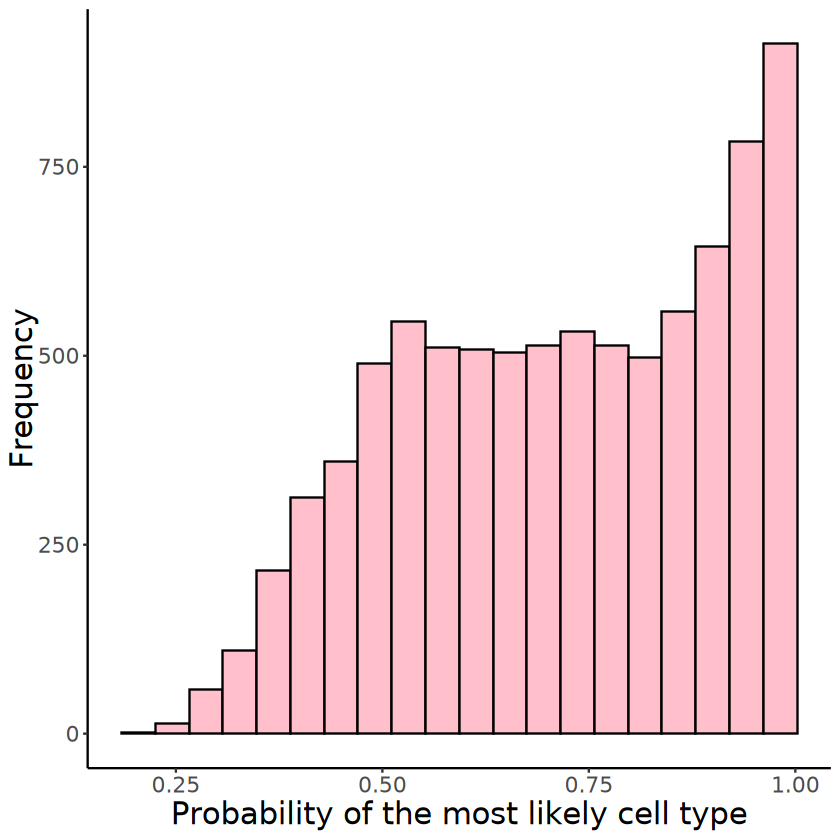

In [11]:
p <- ggplot(NULL, aes(apply(proportions_RCTD, 1, max))) +
    geom_histogram(bins = 20, fill = "pink", color = "black") +
    theme_classic() +
    labs(
        title = NULL,
        x = "Probability of the most likely cell type",
        y = "Frequency"
    ) +
    theme(
        axis.title = element_text(size = 18),
        text = element_text(size = 16),
    )
p
ggsave(
    file = file.path(RESULT_PATH, "hist_most_likely_celltype.pdf"),
    plot = p, width = 5, height = 4
)

In [12]:
mcube_object <- createMCube(
    counts = counts, coordinates = as.matrix(coordinates), 
    proportions = proportions_RCTD, library_sizes = library_sizes_RCTD,
    reference = reference_RCTD, used_for_deconvolution = used_for_deconvolution,
    spot_effects = spot_effects_RCTD, platform_effects = NULL,
    project = seg_method
)
mcube_object <- mcubeFitNull(mcube_object, max_cores = max_cores)
mcube_object <- mcubeTest(mcube_object, max_cores = max_cores)

saveRDS(mcube_object,
    file = file.path(
        RESULT_PATH, seg_method,
        paste0(
            "mcube_object",
            ".rds"
        )
    )
)

pvalues_UCS <- mcube_object@pvalues
saveRDS(pvalues_UCS,
    file = file.path(
        RESULT_PATH, seg_method,
        paste0(
            "mcube_pvalues",
            ".rds"
        )
    )
)

The batch_id is not provided!
All spots are assumed to be from the same batch and share the same gene platform effects.

mcubeFilterCellTypes: Cell types IRF7+ DCs, Mast Cells, LAMP3+ DCs have less than the minimum celltype_threshold = 100. To include these cell-types, please reduce the celltype_threshold.

mcubeFilterCellTypes: Cell types Stromal, Macrophages 1, Perivascular-Like, Myoepi ACTA2+, CD4+ T Cells, DCIS 1, Prolif Invasive Tumor, Invasive Tumor, CD8+ T Cells, Endothelial, Macrophages 2, DCIS 2, B Cells, Myoepi KRT15+ pass the celltype_threshold = 100.

mcubeFilterGenes: Filter genes based on relative expression with threshold = 5e-05.

The platform effects are not provided and need to be estimated from data!

Preprocessed data description: 8588 spots, 292 genes, and 17 cell types in total. 8588 spots and 14 cell types to analyze.

Number of cores used: 36.

mcubeKernel: length scale is set as 0.0234856656686858 for the Gaussian kernel.

mcubeKernel: length scale is set as 0.

## Comparsion of the cell-type-specific SVG identification results

In [13]:
# pvalues_10x <- readRDS(
#     file = file.path(
#         RESULT_PATH, "Cell_10X",
#         paste0(
#             "mcube_pvalues",
#             ".rds"
#         )
#     )
# )
# pvalues_UCS <- readRDS(
#     file = file.path(
#         RESULT_PATH, "UCS_10X",
#         paste0(
#             "mcube_pvalues",
#             ".rds"
#         )
#     )
# )

In [14]:
pvalues_10x_long <- do.call(
    rbind,
    lapply(
        names(pvalues_10x),
        FUN = function(x) {
            data.frame(
                celltype = x,
                gene = rownames(pvalues_10x[[x]]),
                pvalue = pvalues_10x[[x]][, "combined_pvalue"]
            )
        }
    )
)
pvalues_UCS_long <- do.call(
    rbind,
    lapply(
        names(pvalues_UCS),
        FUN = function(x) {
            data.frame(
                celltype = x,
                gene = rownames(pvalues_UCS[[x]]),
                pvalue = pvalues_UCS[[x]][, "combined_pvalue"]
            )
        }
    )
)

pvalues_all <- merge(
    pvalues_10x_long,
    pvalues_UCS_long,
    by = c("celltype", "gene"),
    suffixes = c("_10x", "_UCS")
)
dim(pvalues_all)
head(pvalues_all)

[1] 794   4

celltype gene    pvalue_10x   pvalue_UCS  
1 B Cells  ANKRD28 8.573016e-02 2.298919e-01
2 B Cells  BANK1   2.185740e-09 1.793101e-09
3 B Cells  BASP1   8.515671e-01 1.322339e-01
4 B Cells  C2orf42 5.841524e-01 2.454369e-01
5 B Cells  CCDC6   3.840969e-01 8.925595e-01
6 B Cells  CCPG1   1.848640e-02 3.905222e-03

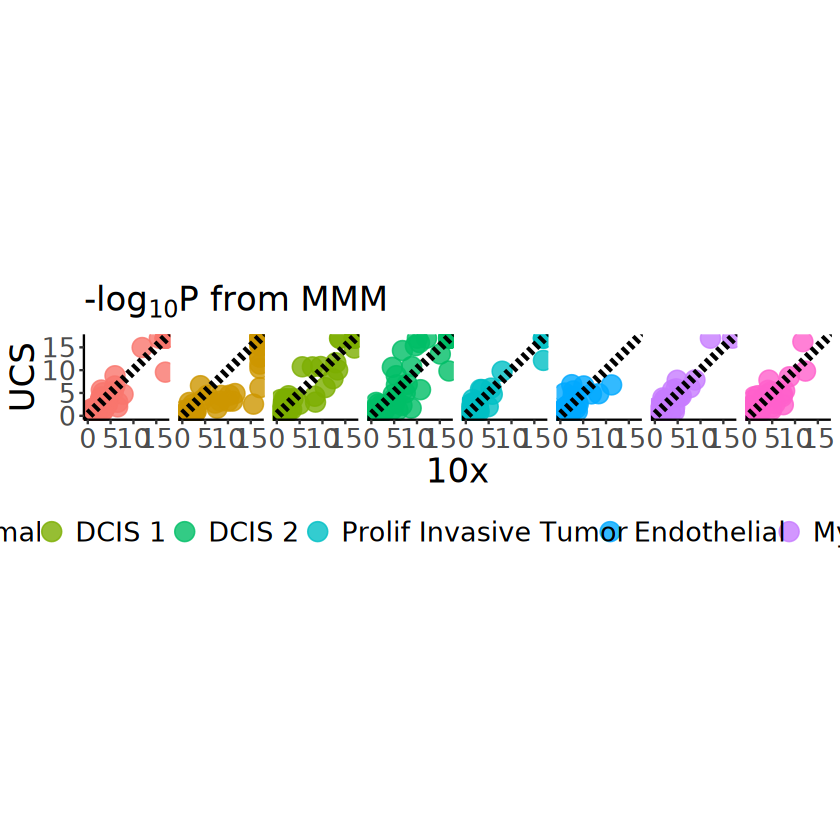

In [15]:
log10p_lim <- 17 # 5.55e-17
# major_celltypes <- mcube_object@celltype_test
major_celltypes <- c(
    "Invasive Tumor", "Stromal", "DCIS 1", "DCIS 2",
    "Prolif Invasive Tumor", "Endothelial", "Myoepi ACTA2+", "Myoepi KRT15+"
)
pvalues_all_major_celltype <- pvalues_all[pvalues_all$celltype %in% major_celltypes, ]
pvalues_all_major_celltype$celltype <- factor(
    pvalues_all_major_celltype$celltype,
    levels = major_celltypes
)

p <- ggplot(
    # pvalues_all,
    pvalues_all_major_celltype,
    aes(x = -log10(pvalue_10x), y = -log10(pvalue_UCS))
) +
    geom_point(aes(color = celltype), size = 5, alpha = 0.8) +
    geom_abline(
        intercept = 0, slope = 1,
        linetype = "longdash", linewidth = 1.5
    ) +
    scale_x_continuous(limits = c(0, log10p_lim), oob = scales::oob_squish) +
    scale_y_continuous(limits = c(0, log10p_lim), oob = scales::oob_squish) +
    coord_fixed(ratio = 1) +
    facet_wrap(~ celltype, nrow = 1) +
    theme_classic() +
    labs(
        x = "10x", y = "UCS",
        title = expression(paste("-log"[10], plain(P), " from MMM"))
    ) +
    guides(color = guide_legend(nrow = 1)) +
    theme(
        plot.title = element_text(size = 20),
        axis.title = element_text(size = 20),
        axis.text.x = element_text(size = 16),
        axis.text.y = element_text(size = 16),
        strip.text = element_blank(),
        legend.title = element_blank(),
        legend.text = element_text(size = 16),
        legend.position = "bottom"
    )
ggsave(
    filename = file.path(
        RESULT_PATH, paste0("MMM_seg_comparison_oob_squish_", log10p_lim, ".pdf")
    ),
    plot = p, width = 18, height = 4
)
p

## Visualization of the identified cell-type-specific SVGs

We then visualize the cell-type-specific SVG identification results of the ST dataset segmented by `UCS`.

In [16]:
# mcube_object <- readRDS(
#     file = file.path(
#         RESULT_PATH, "UCS_10X",
#         paste0(
#             "mcube_object",
#             ".rds"
#         )
#     )
# )

sig_genes <- mcubeGetSigGenes(mcube_object@pvalues)

mcubeGetSigGenes: Set adjust_method as BH and alpha as 0.05.



In [17]:
# Load in H&E image
library(tiff)
library(grid)
library(nara)
he_image <- readTIFF(file.path(DATA_PATH, "he.tif"), native = TRUE)
he_image <- nr_flipv(he_image)
he_image <- nr_fliph(he_image)

### Cell type DCIS 1

In [18]:
celltype <- "DCIS 1"

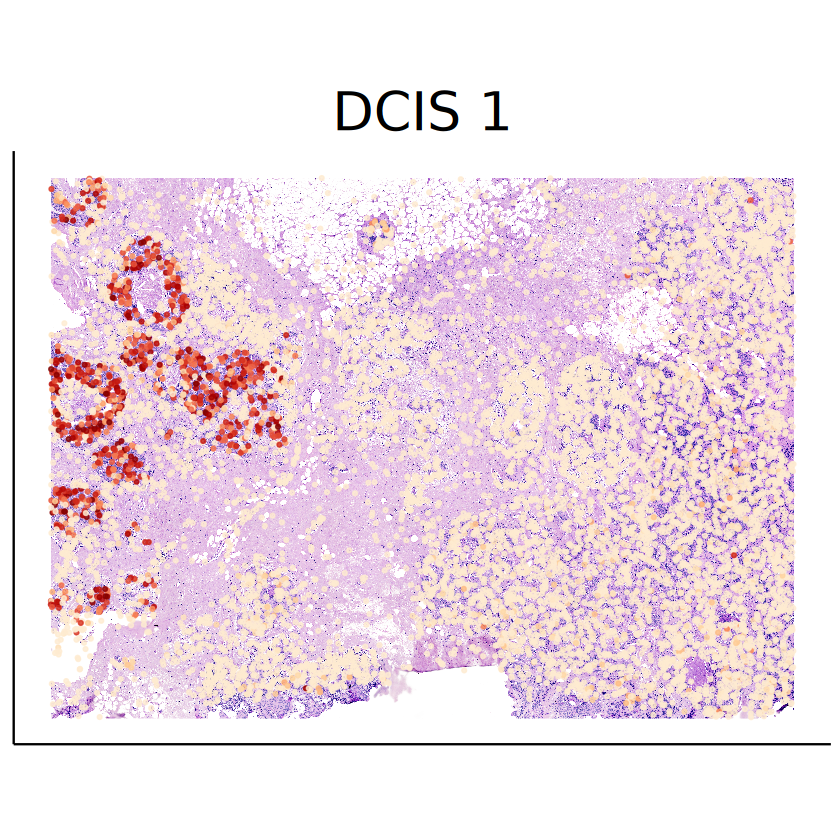

In [19]:
# Cell type proportion
plot_df <- data.frame(
    x = mcube_object@coordinates[, 2],
    y = mcube_object@coordinates[, 1],
    prop = mcube_object@proportions[, celltype]
)
plot_df <- plot_df[plot_df$prop > 0, , drop = FALSE]

p <- ggplot(data = plot_df, aes(x = x, y = y)) + 
annotation_raster(
    he_image,
    xmin = -max(mcube_object@coordinates[, 2]), xmax = 0,
    ymin = 0, ymax = max(mcube_object@coordinates[, 1])
) + 
    geom_point(aes(color = prop), size = 0.7, alpha = 0.8) +
    scale_x_continuous(transform = "reverse") +
    scale_colour_gradientn(name = NULL, colors = pals::brewer.orrd(22)[3:22]) +
    coord_fixed(ratio = 1) +
    labs(title = celltype, x = NULL, y = NULL) +
    theme_classic() +
    theme(
        plot.title = element_text(size = 32, hjust = 0.5),
        text = element_blank(),
        axis.ticks = element_blank(),
        legend.position = "none"
    )
ggsave(
    filename = file.path(RESULT_PATH, paste0(celltype, "_proportion.png")),
    plot = p, width = 7, height = 5
)
p

In [20]:
# Cell-type-specific SVGS
write.table(
    rownames(sig_genes[[celltype]]),
    file = file.path(
        RESULT_PATH,
        paste0(celltype, "_SVG", ".txt")
    ),
    quote = FALSE, row.names = FALSE, col.names = FALSE
)
head(sig_genes[[celltype]])

pvalue       adjusted_pvalue
SERPINA3 1.343131e-66 7.924472e-65   
ESR1     1.917351e-27 5.656186e-26   
ERBB2    8.209624e-25 1.614559e-23   
TACSTD2  3.158104e-22 4.658203e-21   
USP53    4.668377e-19 5.508685e-18   
KLF5     1.070857e-17 1.053010e-16

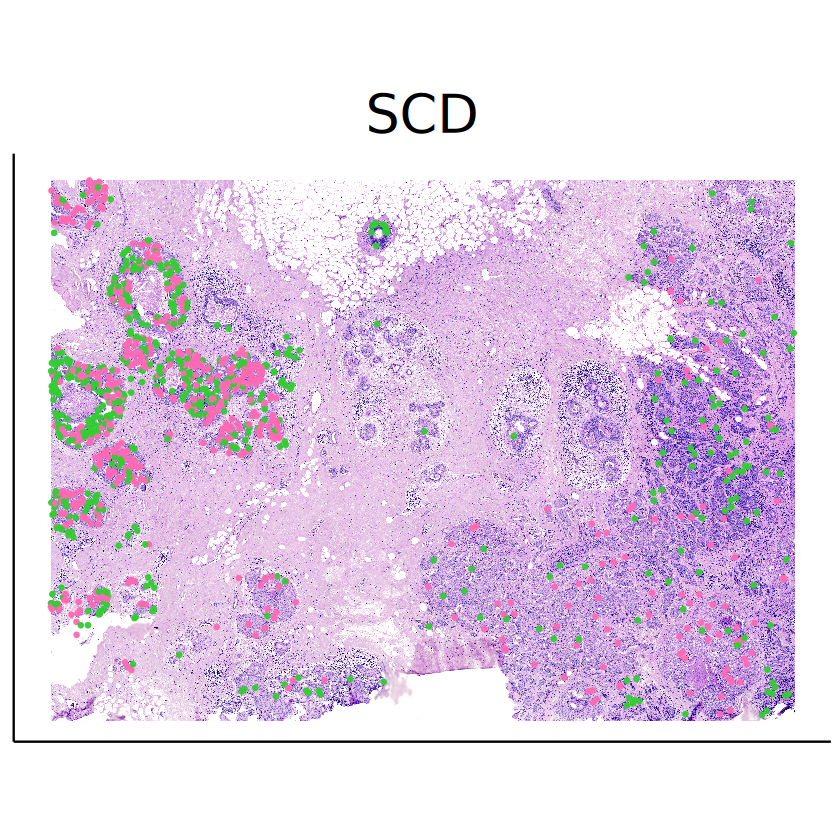

In [21]:
demo_genes <- c("ESR1", "FLNB", "SCD")
for (gene in demo_genes) {
    pair_name <- paste(celltype, gene, sep = "_")
    null_model_results <- mcube_object@null_models[[pair_name]]
    spots <- null_model_results$spots
    u <- null_model_results$u[spots, celltype]
    rel_expr_level <- factor(ifelse(u >= 0, 1, 0))
    plot_df <- data.frame(
        x = mcube_object@coordinates[spots, 2],
        y = mcube_object@coordinates[spots, 1],
        rel_expr_level = rel_expr_level
    )

    p <- ggplot(data = plot_df, aes(x = x, y = y)) +
        annotation_raster(
            he_image,
            xmin = -max(mcube_object@coordinates[, 2]), xmax = 0,
            ymin = 0, ymax = max(mcube_object@coordinates[, 1])
        ) + 
        geom_point(aes(color = rel_expr_level), size = 0.8, alpha = 0.95) +
        scale_color_manual(name = "Level", values = c(`0` = "#32CD32", `1` = "#FF69B4")) +
        scale_x_continuous(transform = "reverse") +
        coord_fixed(ratio = 1) +
        labs(title = gene, x = NULL, y = NULL) +
        theme_classic() +
        theme(
            plot.title = element_text(face = "italic", size = 32, hjust = 0.5),
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            legend.position = "none"
        )
    ggsave(
        filename = file.path(RESULT_PATH, paste0(celltype, "_", gene, ".png")),
        plot = p, width = 7, height = 5
    )
}
p

### Cell type DCIS 2

In [22]:
celltype <- "DCIS 2"

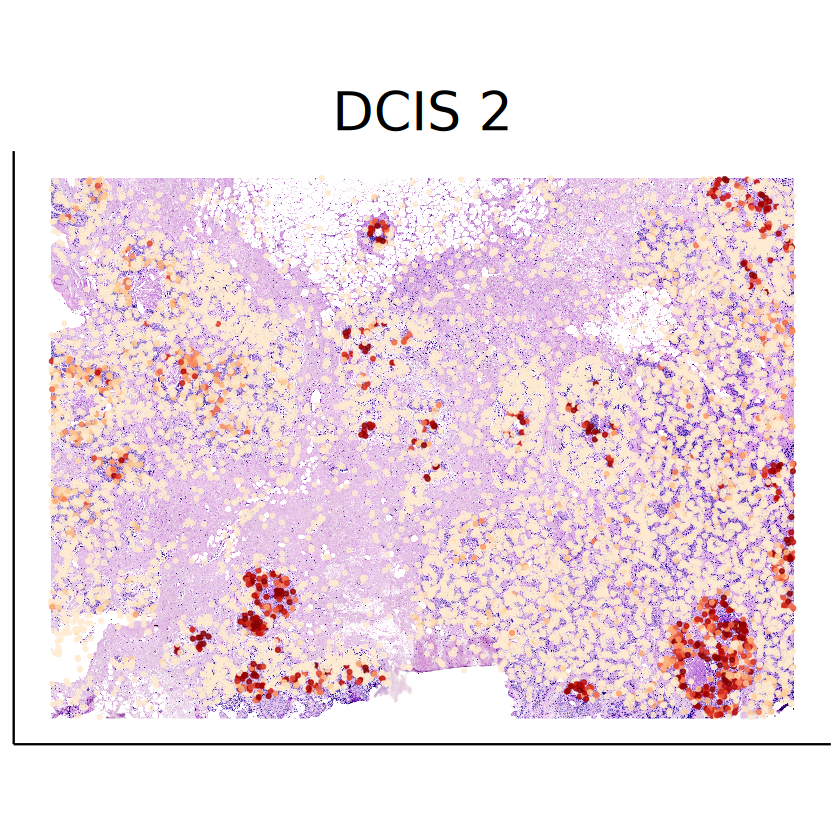

In [23]:
# Cell type proportion
plot_df <- data.frame(
    x = mcube_object@coordinates[, 2],
    y = mcube_object@coordinates[, 1],
    prop = mcube_object@proportions[, celltype]
)
plot_df <- plot_df[plot_df$prop > 0, , drop = FALSE]

p <- ggplot(data = plot_df, aes(x = x, y = y)) + 
annotation_raster(
    he_image,
    xmin = -max(mcube_object@coordinates[, 2]), xmax = 0,
    ymin = 0, ymax = max(mcube_object@coordinates[, 1])
) + 
    geom_point(aes(color = prop), size = 0.7, alpha = 0.8) +
    scale_x_continuous(transform = "reverse") +
    scale_colour_gradientn(name = NULL, colors = pals::brewer.orrd(22)[3:22]) +
    coord_fixed(ratio = 1) +
    labs(title = celltype, x = NULL, y = NULL) +
    theme_classic() +
    theme(
        plot.title = element_text(size = 32, hjust = 0.5),
        text = element_blank(),
        axis.ticks = element_blank(),
        legend.position = "none"
    )
ggsave(
    filename = file.path(RESULT_PATH, paste0(celltype, "_proportion.png")),
    plot = p, width = 7, height = 5
)
p

In [24]:
# Cell-type-specific SVGS
write.table(
    rownames(sig_genes[[celltype]]),
    file = file.path(
        RESULT_PATH,
        paste0(celltype, "_SVG", ".txt")
    ),
    quote = FALSE, row.names = FALSE, col.names = FALSE
)
head(sig_genes[[celltype]])

pvalue        adjusted_pvalue
CEACAM6  8.570957e-121 5.056865e-119  
SCD      3.560130e-106 1.050238e-104  
SERPINA3  3.668939e-97  7.215579e-96  
TENT5C    5.663161e-87  8.353163e-86  
KRT7      4.817492e-69  5.684641e-68  
ERBB2     7.632832e-57  7.505618e-56

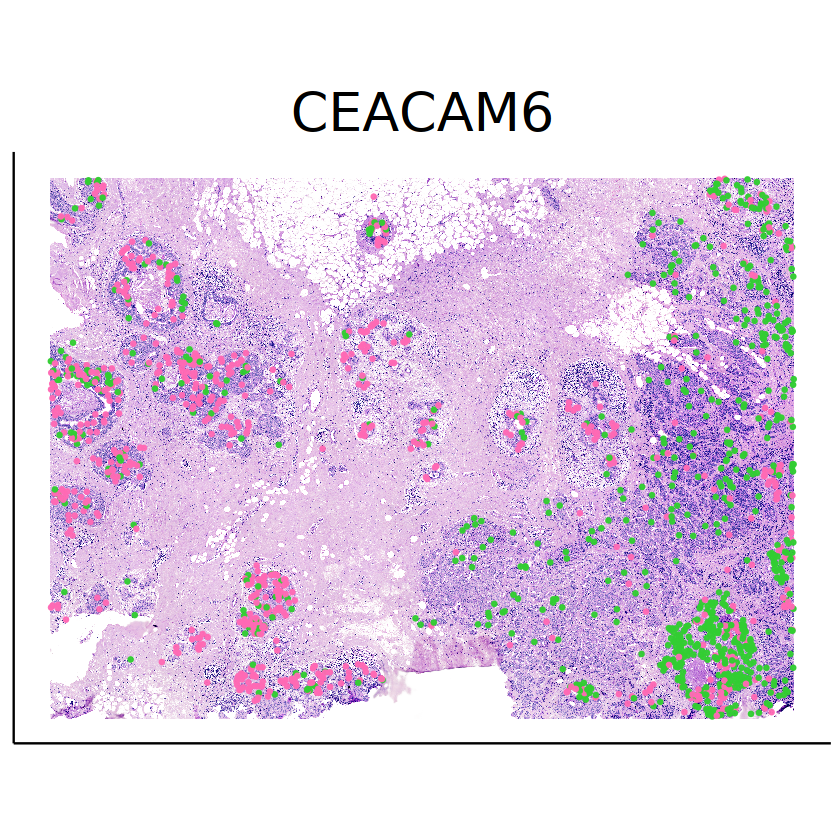

In [25]:
demo_genes <- c("KRT7", "SERPINA3", "CEACAM6")
for (gene in demo_genes) {
    pair_name <- paste(celltype, gene, sep = "_")
    null_model_results <- mcube_object@null_models[[pair_name]]
    spots <- null_model_results$spots
    u <- null_model_results$u[spots, celltype]
    rel_expr_level <- factor(ifelse(u >= 0, 1, 0))
    plot_df <- data.frame(
        x = mcube_object@coordinates[spots, 2],
        y = mcube_object@coordinates[spots, 1],
        rel_expr_level = rel_expr_level
    )

    p <- ggplot(data = plot_df, aes(x = x, y = y)) +
        annotation_raster(
            he_image,
            xmin = -max(mcube_object@coordinates[, 2]), xmax = 0,
            ymin = 0, ymax = max(mcube_object@coordinates[, 1])
        ) + 
        geom_point(aes(color = rel_expr_level), size = 0.8, alpha = 0.95) +
        scale_color_manual(name = "Level", values = c(`0` = "#32CD32", `1` = "#FF69B4")) +
        scale_x_continuous(transform = "reverse") +
        coord_fixed(ratio = 1) +
        labs(title = gene, x = NULL, y = NULL) +
        theme_classic() +
        theme(
            plot.title = element_text(face = "italic", size = 32, hjust = 0.5),
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            legend.position = "none"
        )
    ggsave(
        filename = file.path(RESULT_PATH, paste0(celltype, "_", gene, ".png")),
        plot = p, width = 7, height = 5
    )
}
p

Some of cell-type-specific SVGs exhibit distinct expression patterns across different spatial domains, suggesting that these spatial variations were driven by the activities of other cells in the niche of the target cell type with high probability.
For example, the expression levels of *CEACAM6* and *SERPINA3* in DCIS 2 cells seem to be affected by surrounding Invasive Tumor cells.

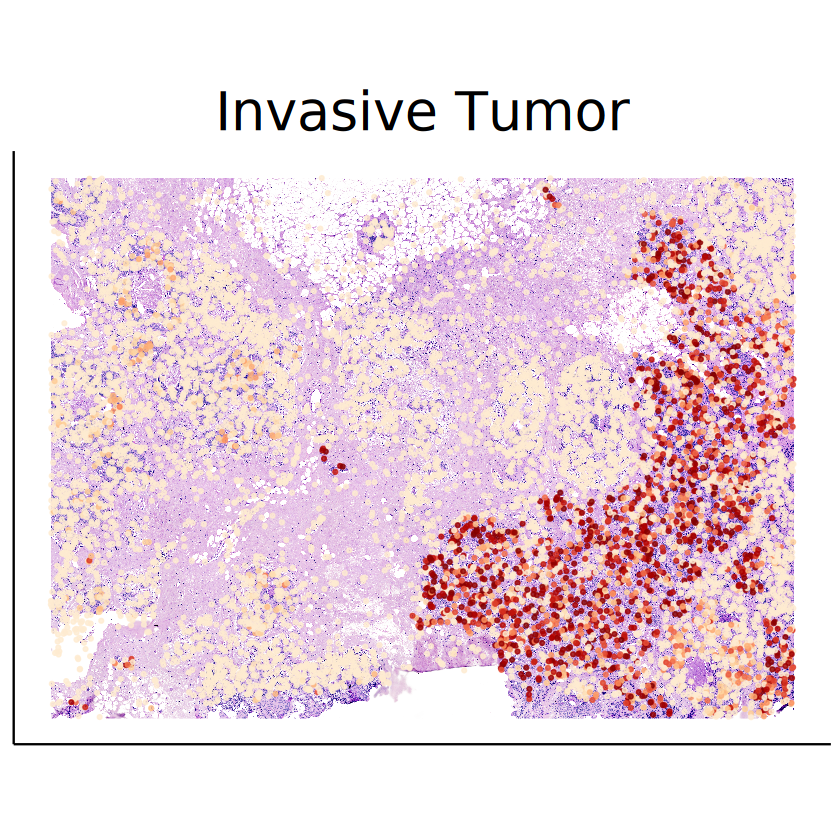

In [26]:
celltype <- "Invasive Tumor"
plot_df <- data.frame(
    x = mcube_object@coordinates[, 2],
    y = mcube_object@coordinates[, 1],
    prop = mcube_object@proportions[, celltype]
)
plot_df <- plot_df[plot_df$prop > 0, , drop = FALSE]

p <- ggplot(data = plot_df, aes(x = x, y = y)) + 
annotation_raster(
    he_image,
    xmin = -max(mcube_object@coordinates[, 2]), xmax = 0,
    ymin = 0, ymax = max(mcube_object@coordinates[, 1])
) + 
    geom_point(aes(color = prop), size = 0.7, alpha = 0.8) +
    scale_x_continuous(transform = "reverse") +
    scale_colour_gradientn(name = NULL, colors = pals::brewer.orrd(22)[3:22]) +
    coord_fixed(ratio = 1) +
    labs(title = celltype, x = NULL, y = NULL) +
    theme_classic() +
    theme(
        plot.title = element_text(size = 32, hjust = 0.5),
        text = element_blank(),
        axis.ticks = element_blank(),
        legend.position = "none"
    )
ggsave(
    filename = file.path(RESULT_PATH, paste0(celltype, "_proportion.png")),
    plot = p, width = 7, height = 5
)
p